# Data Analysis for B04 Data Analytics at WU Executive Academy

In [1]:
# Core Dataset was taken from KAGGLE https://www.kaggle.com/datasets/mikhail1681/walmart-sales
# Analysis was performed for course B04 Data Analytics at WU Executive Academy
# 2024 David Fischanger
#
# Importing the basic librarires
!pip install statsmodels

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset with semicolon separatoqsar as US dataset for exporting it into European standard ";"
df = pd.read_csv('../input/walmart-sales/Walmart_sales.csv', sep=',')

display(df.head())
original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))


Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106


Inference: The Dataset consists of 8 features & 6435 samples.


In [3]:
# Convert 'Date' to datetime format specifying the european date format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Extracting 'weekday', 'month', and 'year' from 'Date'
df['weekday'] = df['Date'].dt.weekday
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# Dropping the original 'Date' column
df.drop(['Date'], axis=1, inplace=True)

# Setting the target variable for our analysis
target = 'Weekly_Sales'

# Creating a list of feature columns, excluding the target
features = [i for i in df.columns if i not in [target]]

# Creating a copy of the dataframe for future use
original_df = df.copy(deep=True)

# Displaying the first few rows of the modified dataframe
df.head()


Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   Unemployment  weekday  month  year  
0         8.106        4      2  2010  
1         8.106        4      2  2010  
2         8.106        4      2  2010  
3         8.106        4      2  2010  
4         8.106        4      3  2010

## Descriptive Analysis

In [4]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int32  
 8   month         6435 non-null   int32  
 9   year          6435 non-null   int32  
dtypes: float64(5), int32(3), int64(2)
memory usage: 427.4 KB


In [5]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

weekday            1
Holiday_Flag       2
year               3
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [6]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 5 categorical features.


In [7]:
#Checking the stats of all the columns

display(df.describe())

Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  weekday        month         year  
count  6435.000000   6435.000000   6435.0  6435.000000  6435.000000  
mean    171.578394      7.999151      4.0     6.447552  2010.965035  
std      39.356712      1.875885      0.0     3.238308     0.797019  
min     126.064000      3.879000      4.0     1.000000  2010.000000  
25%     131.735000      6.891000      4.0     4.000000  2010.000000  
50%     182.616521      7.874000      4.0     6.000000  2011.000000  
75%     212.743293      8.622000      4.0     9.000000  2012.000000  
max     227.232807     14.313000      4.0    12.000000  2012.000000

# Cluster Analysis Total Sales

As we will not find any linear correlations in that dataset (in the later steps). I was playing with the idea to find some linear correlation by segmenting the Store IDs

In [8]:
# Aggregate 'Weekly_Sales' by 'Store'
sales_by_store = df.groupby('Store')['Weekly_Sales'].sum().reset_index()

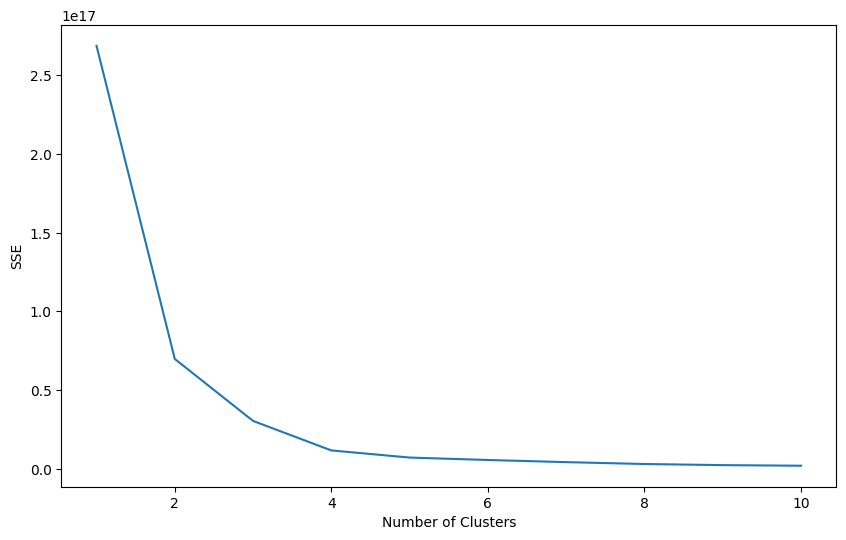

In [9]:
# Perform clustering on the aggregated sales data
# Determine the optimal number of clusters (k) using the Elbow method 
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(sales_by_store[['Weekly_Sales']])
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# We're taking 3 clusters, as this fits best the elbow method
kmeans = KMeans(n_clusters=3, max_iter=1000)
sales_by_store['Cluster'] = kmeans.fit_predict(sales_by_store[['Weekly_Sales']])

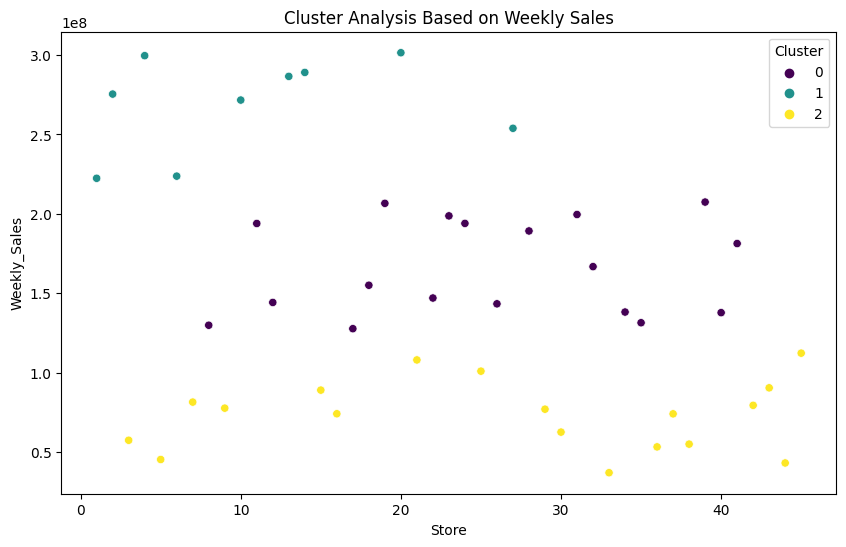

In [10]:
# Plotting the clusters using SNS
sns.scatterplot(x='Store', y='Weekly_Sales', hue='Cluster', data=sales_by_store, palette='viridis')
plt.title('Cluster Analysis Based on Weekly Sales')
plt.show()

In [11]:
# Displaying stores based on their cluster
for cluster in sorted(sales_by_store['Cluster'].unique()):
    print(f"Cluster {cluster + 1}:")
    stores_in_cluster = sales_by_store[sales_by_store['Cluster'] == cluster]['Store']
    print("Stores:", list(stores_in_cluster))
    print()

Cluster 1:
Stores: [8, 11, 12, 17, 18, 19, 22, 23, 24, 26, 28, 31, 32, 34, 35, 39, 40, 41]

Cluster 2:
Stores: [1, 2, 4, 6, 10, 13, 14, 20, 27]

Cluster 3:
Stores: [3, 5, 7, 9, 15, 16, 21, 25, 29, 30, 33, 36, 37, 38, 42, 43, 44, 45]



In [12]:
# Save the information in a dataset called "Store_Cluster" and include the aggregated "Weekly_Sales" for later analysis in JMP
store_cluster = sales_by_store[['Store', 'Weekly_Sales', 'Cluster']]
store_cluster.to_csv('Store_Cluster.csv', index=False)

# Cluster Analysis based Weekly Sales Trend

I was doing the same Clustering Idea by finding a weekly Sales Trend YoY - doing a linear correlation by segmenting the Store IDs


In [13]:
def cluster_stores_by_sales_trend(df):
    # Aggregate 'Weekly_Sales' by 'year' by 'Store'
    aggregated_sales = df.groupby(['Store', 'year'])['Weekly_Sales'].sum().reset_index()

    # Filter for the years 2010, 2011, and 2012
    filtered_sales = aggregated_sales[aggregated_sales['year'].isin([2010, 2011, 2012])]
    
    # Pivot to get a clearer view
    sales_pivot = filtered_sales.pivot(index='Store', columns='year', values='Weekly_Sales').reset_index()

    # Print a sorted list of stores including aggregated sales for 2010, 2011, and 2012
    sorted_sales = sales_pivot.sort_values('Store')
    print(sorted_sales)
    # Create clusters based on sales trend
    def classify_trend(row):
        if row[2010] < row[2011] and row[2011] < row[2012]:
            return 'Increasing'  # Cluster 0
        elif row[2010] > row[2011] and row[2011] > row[2012]:
            return 'Decreasing'  # Cluster 2
        return 'Stable'  # Cluster 1

    sorted_sales['Cluster'] = sorted_sales.apply(classify_trend, axis=1)
    
        # Display stores based on their cluster
    for cluster in sorted(sorted_sales['Cluster'].unique()):
        print(f"Cluster {cluster}:")
        stores_in_cluster = sorted_sales[sorted_sales['Cluster'] == cluster]['Store']
        print("Stores:", list(stores_in_cluster))
        print()

    return sorted_sales[['Store', 'Cluster']]

# Apply the function to our DataFrame
store_cluster = cluster_stores_by_sales_trend(df)
# save the resulting cluster assignment to a CSV file
store_cluster.to_csv('Store_Cluster.csv', index=False)

year  Store          2010          2011         2012
0         1  7.327883e+07  8.092192e+07  68202058.02
1         2  9.527786e+07  9.860788e+07  81496695.37
2         3  1.874542e+07  2.081688e+07  18024439.50
3         4  9.568047e+07  1.110923e+08  92771189.24
4         5  1.483603e+07  1.647082e+07  14168838.13
5         6  7.691232e+07  8.052876e+07  66315047.00
6         7  2.556808e+07  3.066264e+07  25367556.47
7         8  4.320447e+07  4.751279e+07  39233920.13
8         9  2.512922e+07  2.868597e+07  23974029.58
9        10  9.447220e+07  9.891689e+07  78228616.94
10       11  6.525514e+07  7.052358e+07  58184065.68
11       12  4.837038e+07  5.258200e+07  43334845.72
12       13  9.527274e+07  1.045375e+08  86707455.02
13       14  1.054622e+08  1.060963e+08  77441398.26
14       15  3.202353e+07  3.228262e+07  24827530.71
15       16  2.472863e+07  2.742137e+07  22102425.32
16       17  4.110492e+07  4.639184e+07  40285378.63
17       18  5.597842e+07  5.421774e+07  44918

# Distribution

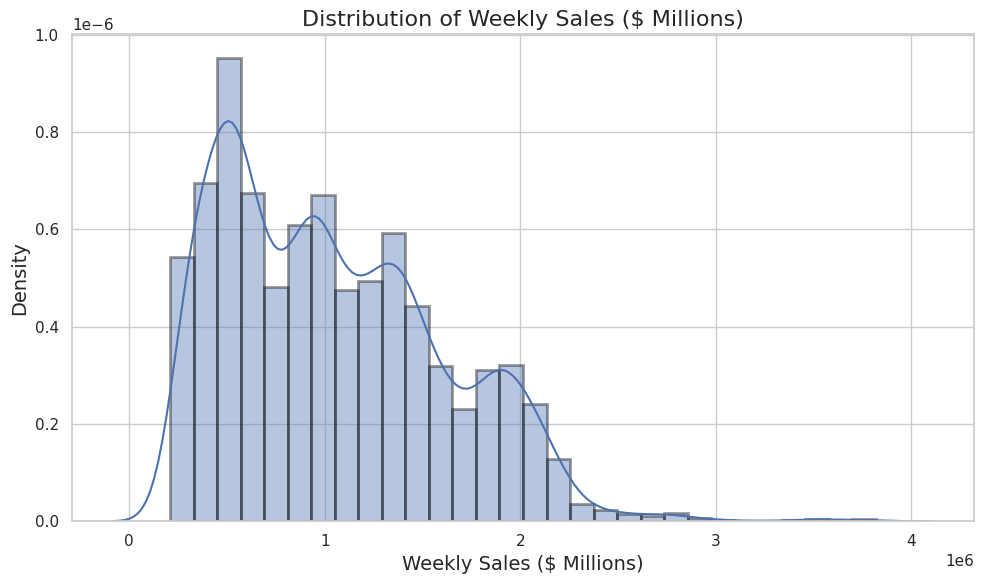

In [14]:
# distribution of the target variable "Weekly Sales"
sns.set_theme(style="whitegrid")
plt.figure(figsize=[10,6], dpi=100)
sns.distplot(df[target], color='b', hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Distribution of Weekly Sales ($ Millions)', fontsize=16)
plt.xlabel('Weekly Sales ($ Millions)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tight_layout()
plt.show()



## Categorical Features

                               Visualising Categorical Features:                                


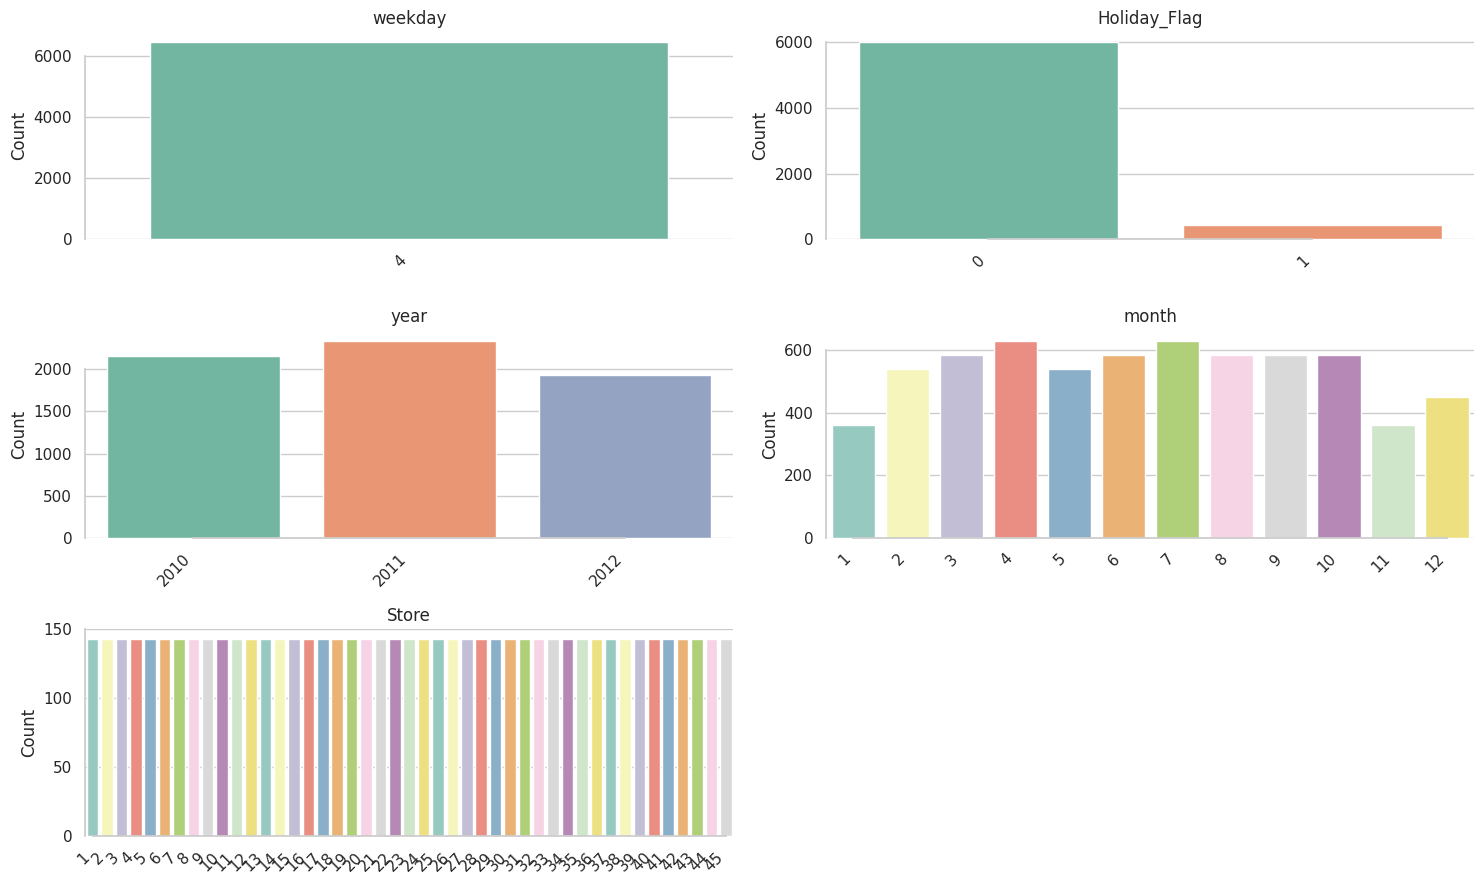

In [15]:
sns.set_theme(style="whitegrid")
print('\033[1mVisualising Categorical Features:'.center(100))

n = 2
plt.figure(figsize=[15, 3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    plt.subplot(math.ceil(len(cf)/n), n, i+1)
    if df[cf[i]].nunique() <= 8:
        sns.countplot(x=cf[i], data=df, palette='Set2')
    else:
        sns.countplot(x=cf[i], data=df, palette='Set3')
    plt.title(cf[i])
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha="right")

plt.subplots_adjust(hspace=0.4, wspace=0.4)
sns.despine(trim=True)
plt.tight_layout()
plt.show()


## Numeric Features

                                                Numeric Features Distribution                                                 


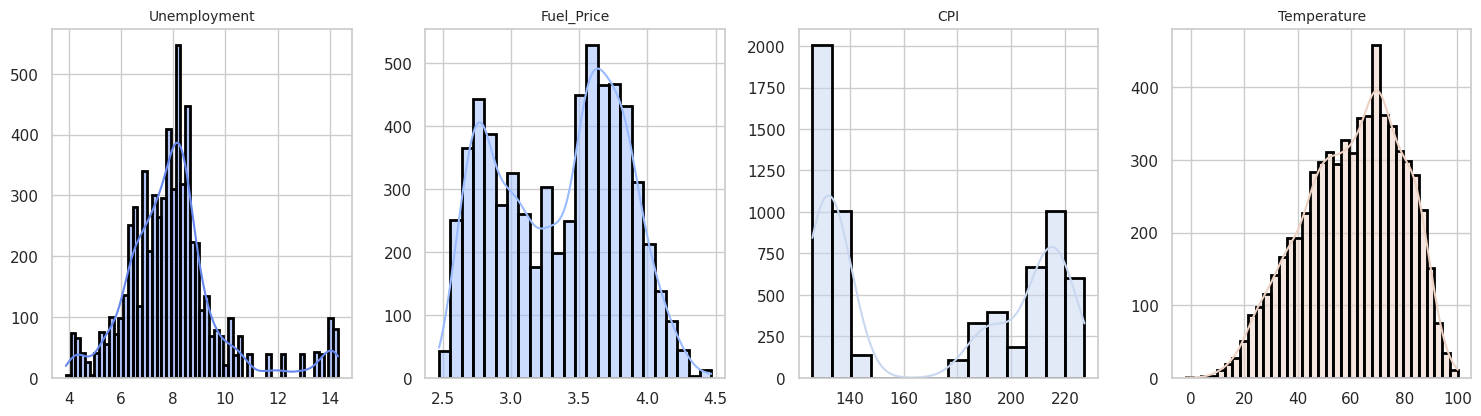

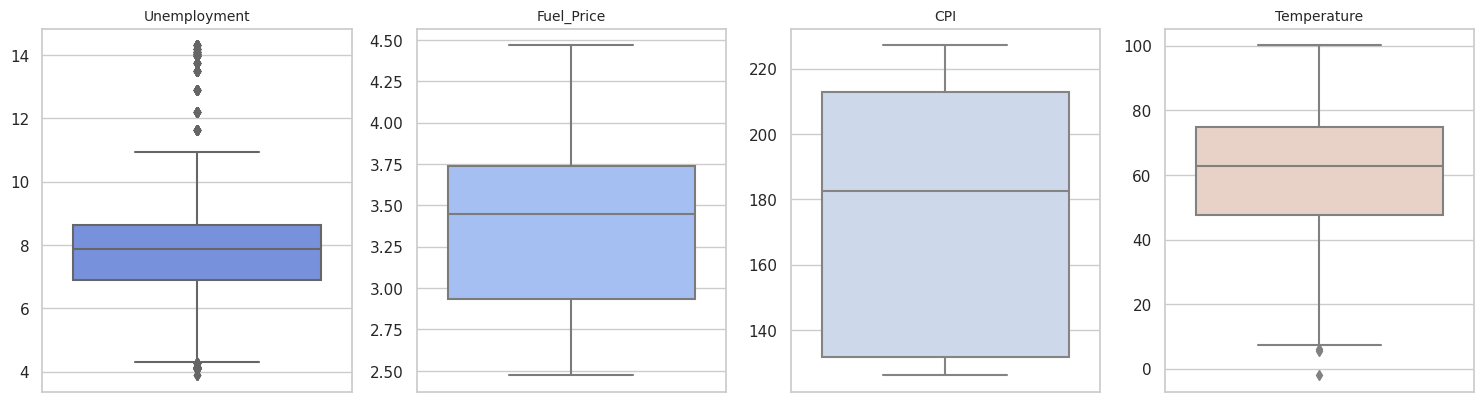

In [16]:
# Set theme for nicer plots
sns.set_theme(style="whitegrid")

print('\033[1mNumeric Features Distribution'.center(130))

n = 4
plt.figure(figsize=[15, 8*math.ceil(len(nf)/n)])

# Distribution Plots
for i, feature in enumerate(nf):
    plt.subplot(math.ceil(len(nf)/3), n, i+1)
    sns.histplot(df[feature], kde=True, color=sns.color_palette("coolwarm")[i % len(sns.color_palette("coolwarm"))], edgecolor="black", linewidth=2)
    plt.title(feature, fontsize=10)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=[15, 8*math.ceil(len(nf)/n)])
for i, feature in enumerate(nf):
    plt.subplot(math.ceil(len(nf)/3), n, i+1)
    sns.boxplot(y=df[feature], color=sns.color_palette("coolwarm")[i % len(sns.color_palette("coolwarm"))])
    plt.title(feature, fontsize=10)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


## Scatterplot

We're using scatterplots for finding a relationship between all features

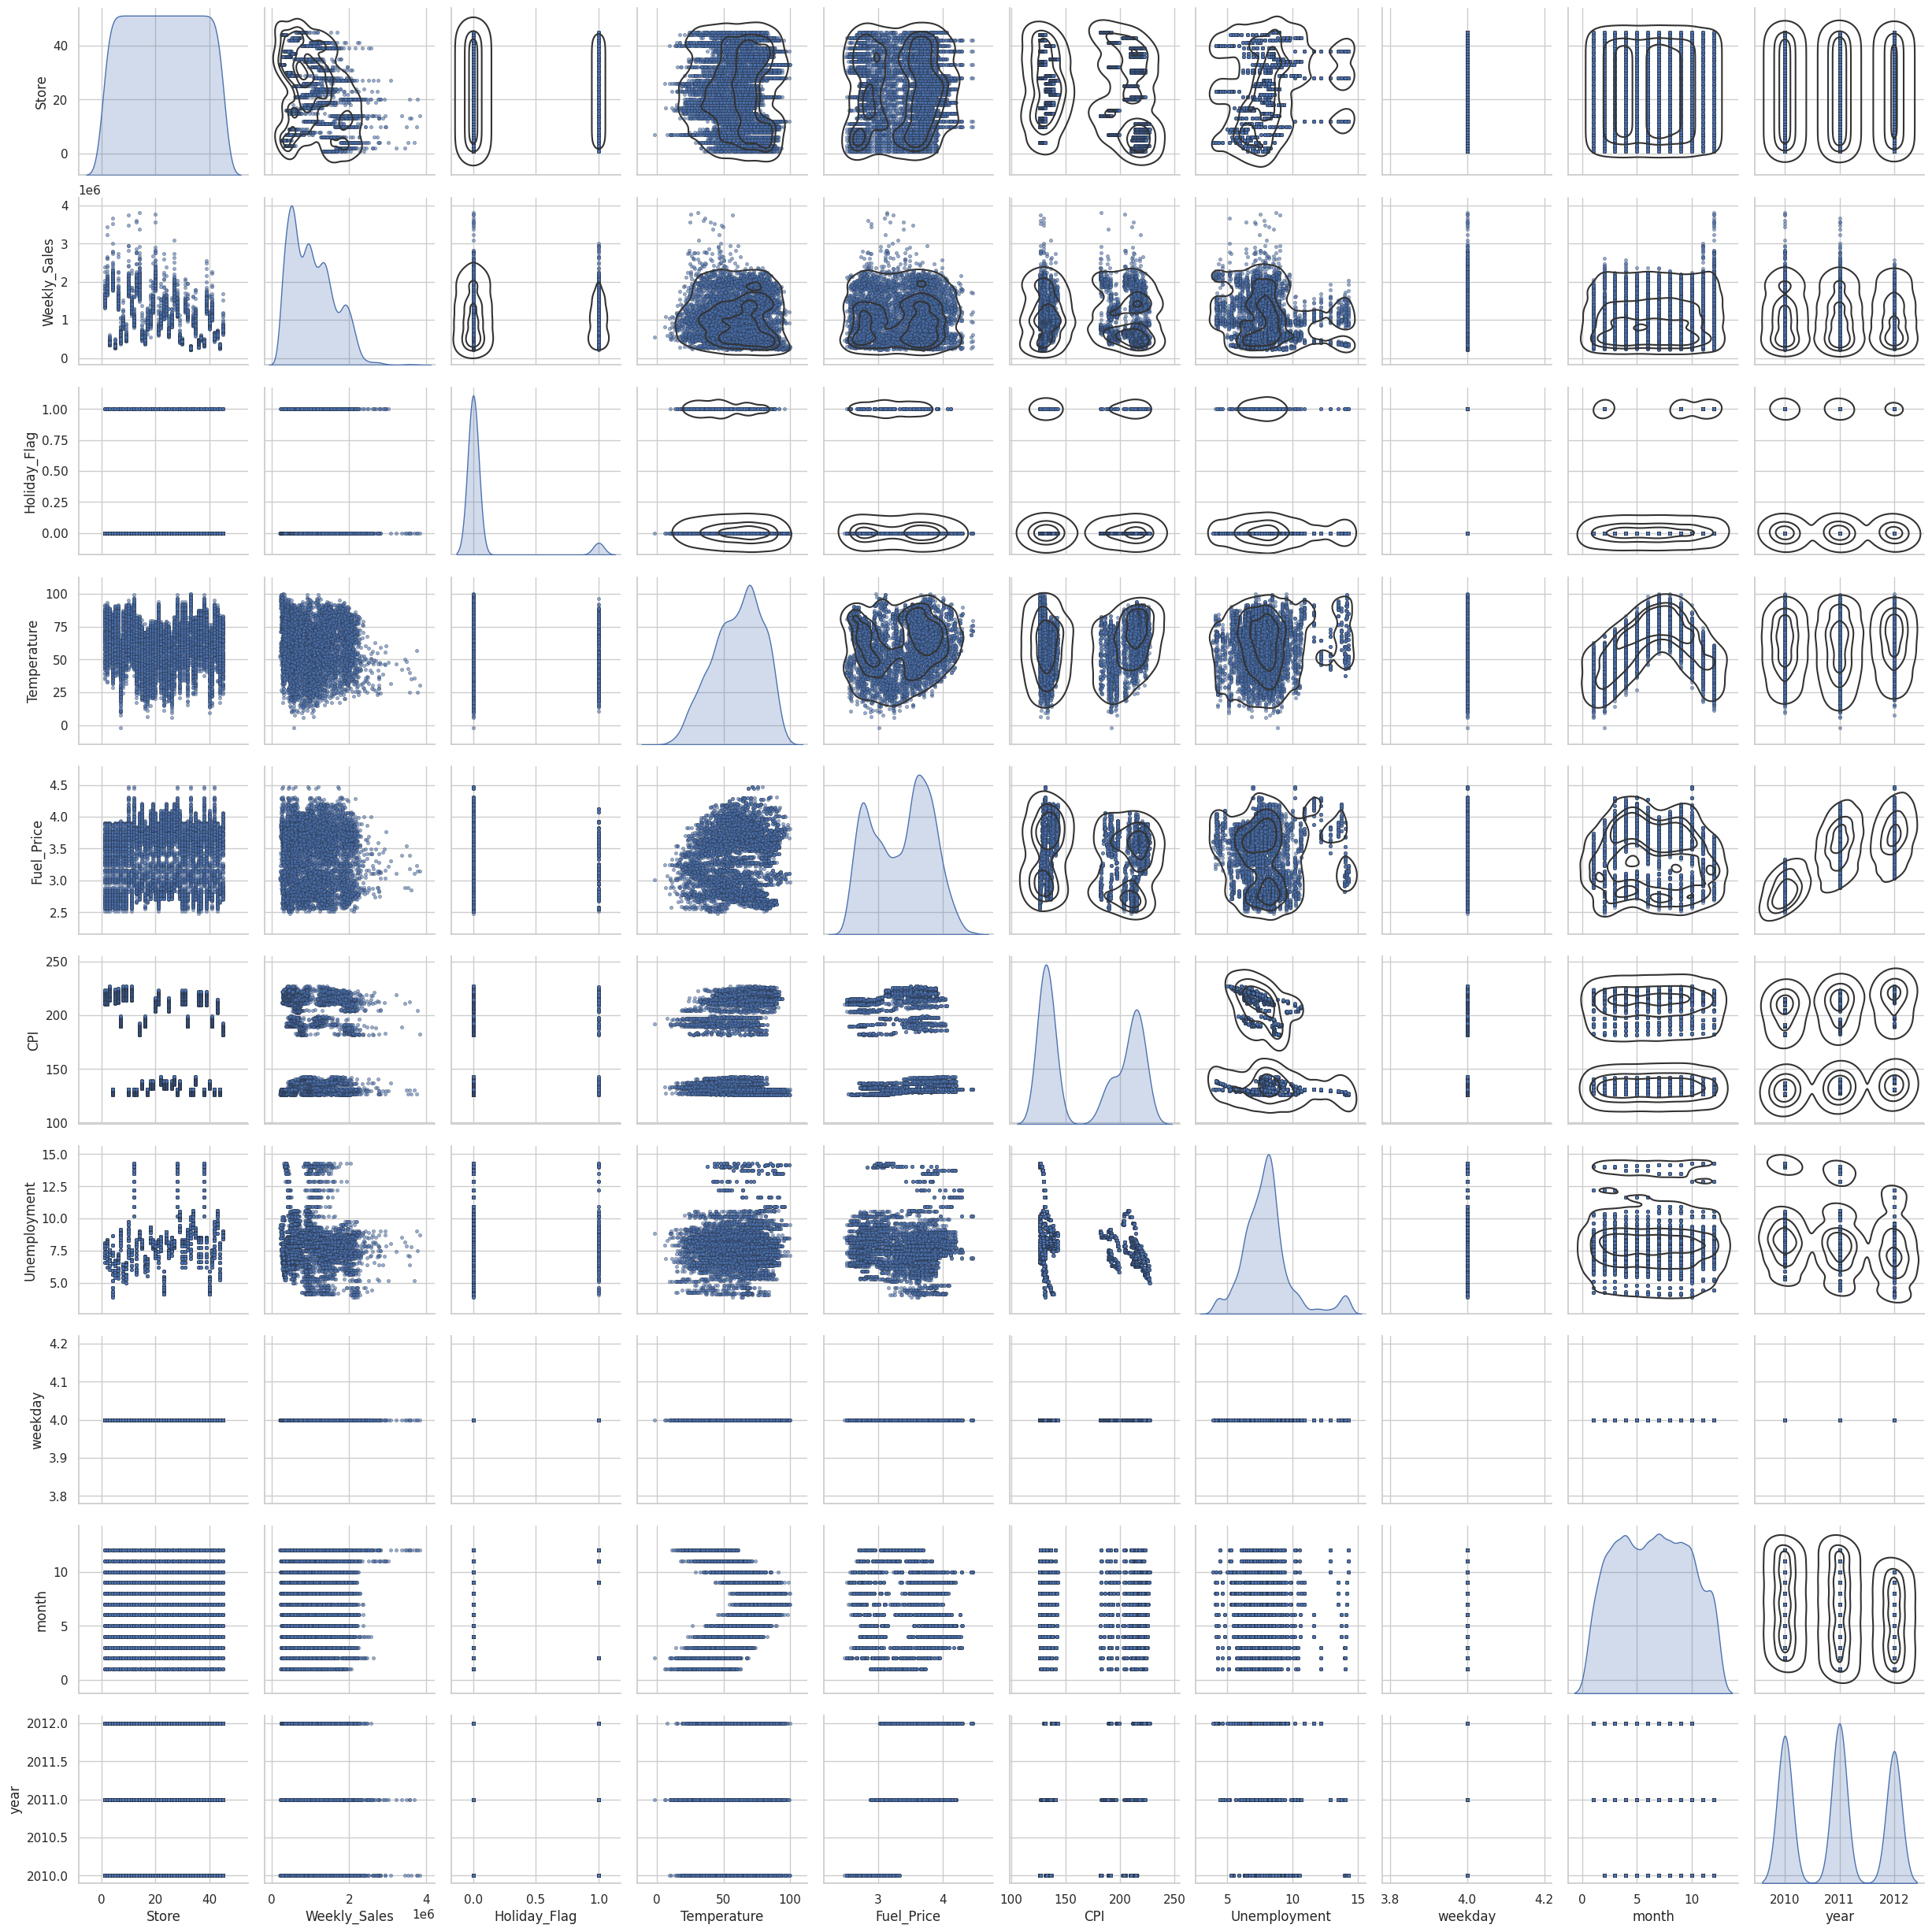

In [17]:
#Using Scatterplot for Relationship between all features

# Set the overall aesthetics
sns.set_theme(style="whitegrid")
palette = sns.color_palette("coolwarm", as_cmap=True)

# Create a pairplot
g = sns.pairplot(df, palette="coolwarm", diag_kind='kde', plot_kws={'alpha': 0.6, 's': 10, 'edgecolor': 'k'})

# Customize the upper triangle
g.map_upper(sns.kdeplot, levels=4, color=".2")

plt.savefig("Python_Scatterplot.png")
plt.show()

We realize that some features have linear relationship, therefore next step is to further analyze multicollinearity

# Data Preprocessing

## Search for Duplicates

In [18]:
counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The datas doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The datas doesn't have any duplicates


## Search for zero values

In [19]:
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
weekday                       0         0.0
month                         0         0.0
year                          0         0.0


## Converting categorical Columns to Numeric

In [20]:
df3 = df.copy()

#  'nvc' is a DataFrame with columns 'Feature' and 'Percentage', and 'cf' is a list of categorical feature names
ecc = nvc[nvc['Percentage'] != 0].index.values  # Features with non-zero percentage to encode
fcc = [i for i in cf if i not in ecc]  # Final list of categorical features to encode

print("\033[1mOne-Hot Encoding applied on features:\033[0m")
for i in fcc:
    n_unique_values = df3[i].nunique()
    if n_unique_values == 2:
        print(i)
        # Apply one-hot encoding for binary features
        df3[i] = pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    elif n_unique_values > 2:
        print(i)
        # Apply dummy encoding for features with more than two unique values
        dummies = pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
        df3 = pd.concat([df3.drop([i], axis=1), dummies], axis=1)

print(df3.shape)


One-Hot Encoding applied on features:
Holiday_Flag
year
month
Store
(6435, 64)


## Final Dataset after Cleaning

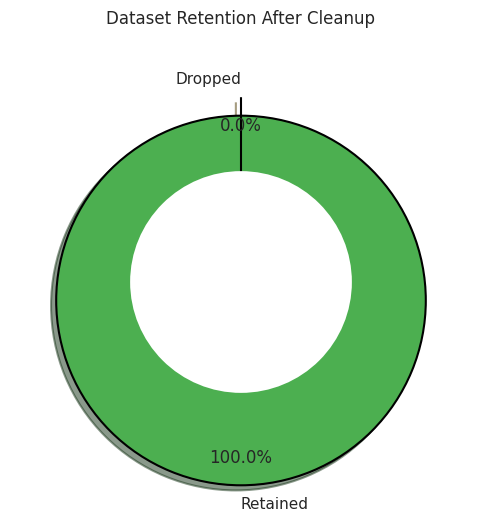


Inference: After the cleanup process, 0 samples were dropped, retaining 100.0% of the data.


In [21]:
import matplotlib.pyplot as plt

#  df is our cleaned dataframe and original_df is the original one
df1 = df3.copy()
df = df1.copy()
df.columns = [i.replace('-', '_') for i in df.columns]

# Use color scheme and aesthetics
colors = ['#4CAF50', '#FFC107']
explode = (0.1, 0) 

plt.figure(figsize=(8, 6))  
plt.pie([df.shape[0], original_df.shape[0] - df.shape[0]],
        labels=['Retained', 'Dropped'],
        counterclock=False,
        autopct='%1.1f%%',
        pctdistance=0.85,
        explode=explode,
        shadow=True,
        startangle=90,
        colors=colors,
        wedgeprops={"edgecolor": "0",'linewidth': 1.5, 'linestyle': 'solid', 'antialiased': True})


centre_circle = plt.Circle((0, 0), 0.6, color='black', fc='white', linewidth=0)
fig = plt.gcf()  
fig.gca().add_artist(centre_circle)

plt.title('Dataset Retention After Cleanup', pad=20)
plt.show()

# Printing the inference with formatting
retained_samples = df.shape[0]
dropped_samples = original_df.shape[0] - df.shape[0]
retained_percentage = round((retained_samples * 100) / original_df.shape[0], 2)

print(f'\n\033[1mInference:\033[0m After the cleanup process, {dropped_samples} samples were dropped, \
retaining {retained_percentage}% of the data.')


Important here: we've found 48 "Outliers, but which are linked to significantly higher sales in the week of Thanksgiving and Christmas. It would be a failure to remove them, hence 0 values have been dropped

# Model Creation

In [22]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (6435, 63) (6435,) 
Training set  --->  (5148, 63) (5148,) 
Testing set   --->  (1287, 63)  (1287,)


## Standardization

In [23]:
# Standardization

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


Holiday_Flag   Temperature    Fuel_Price           CPI  Unemployment  \
count  5.148000e+03  5.148000e+03  5.148000e+03  5.148000e+03  5.148000e+03   
mean   7.522257e-17 -2.553427e-16 -1.449242e-16 -4.968830e-17 -1.849509e-16   
std    1.000097e+00  1.000097e+00  1.000097e+00  1.000097e+00  1.000097e+00   
min   -2.786823e-01 -2.981747e+00 -1.922335e+00 -1.162931e+00 -2.221388e+00   
25%   -2.786823e-01 -7.250120e-01 -9.275490e-01 -1.020104e+00 -5.955842e-01   
50%   -2.786823e-01  1.148294e-01  1.835670e-01  2.809851e-01 -6.492302e-02   
75%   -2.786823e-01  7.682801e-01  8.217521e-01  1.042883e+00  3.248191e-01   
max    3.588316e+00  2.140202e+00  2.417758e+00  1.406786e+00  3.379946e+00   

       weekday     year_2011     year_2012       month_2       month_3  ...  \
count   5148.0  5.148000e+03  5.148000e+03  5.148000e+03  5.148000e+03  ...   
mean       0.0 -8.005338e-17  2.760461e-18 -4.968830e-17 -6.901153e-19  ...   
std        0.0  1.000097e+00  1.000097e+00  1.000097e+00  1.000097e+00  ...   
min        0.0 -7.537095e-01 -6.530191e-01 -3.026600e-01 -3.199304e-01  ...   
25%        0.0 -7.537095e-01 -6.530191e-01 -3.026600e-01 -3.199304e-01  ...   
50%        0.0 -7.537095e-01 -6.530191e-01 -3.026600e-01 -3.199304e-01  ...   
75%        0.0  1.326771e+00  1.531349e+00 -3.026600e-01 -3.199304e-01  ...   
max        0.0  1.326771e+00  1.531349e+00  3.304038e+00  3.125680e+00  ...   

           Store_36      Store_37      Store_38      Store_39      Store_40  \
count  5.148000e+03  5.148000e+03  5.148000e+03  5.148000e+03  5.148000e+03   
mean  -6.901153e-18 -2.415404e-17 -4.485750e-17  6.211038e-18 -3.036507e-17   
std    1.000097e+00  1.000097e+00  1.000097e+00  1.000097e+00  1.000097e+00   
min   -1.477635e-01 -1.463850e-01 -1.524986e-01 -1.551452e-01 -1.449945e-01   
25%   -1.477635e-01 -1.463850e-01 -1.524986e-01 -1.551452e-01 -1.449945e-01   
50%   -1.477635e-01 -1.463850e-01 -1.524986e-01 -1.551452e-01 -1.449945e-01   
75%   -1.477635e-01 -1.463850e-01 -1.524986e-01 -1.551452e-01 -1.449945e-01   
max    6.767570e+00  6.831301e+00  6.557439e+00  6.445576e+00  6.896814e+00   

           Store_41      Store_42      Store_43      Store_44      Store_45  
count  5.148000e+03  5.148000e+03  5.148000e+03  5.148000e+03  5.148000e+03  
mean   2.346392e-17  2.760461e-18  1.173196e-17 -4.830807e-18 -6.211038e-18  
std    1.000097e+00  1.000097e+00  1.000097e+00  1.000097e+00  1.000097e+00  
min   -1.504859e-01 -1.558004e-01 -1.531641e-01 -1.477635e-01 -1.518304e-01  
25%   -1.504859e-01 -1.558004e-01 -1.531641e-01 -1.477635e-01 -1.518304e-01  
50%   -1.504859e-01 -1.558004e-01 -1.531641e-01 -1.477635e-01 -1.518304e-01  
75%   -1.504859e-01 -1.558004e-01 -1.531641e-01 -1.477635e-01 -1.518304e-01  
max    6.645141e+00  6.418467e+00  6.528945e+00  6.767570e+00  6.586297e+00  

[8 rows x 63 columns]


                                          Standardardization on Testing set                                          


Holiday_Flag  Temperature   Fuel_Price          CPI  Unemployment  \
count   1287.000000  1287.000000  1287.000000  1287.000000   1287.000000   
mean      -0.041314     0.025211     0.027495    -0.033202     -0.047740   
std        0.928563     0.996777     0.990103     0.998831      1.033862   
min       -0.278682    -3.393540    -1.831010    -1.162931     -2.221388   
25%       -0.278682    -0.666765    -0.907979    -1.016097     -0.623768   
50%       -0.278682     0.111037     0.230317    -0.742990     -0.081028   
75%       -0.278682     0.813794     0.843496     1.016348      0.296635   
max        3.588316     2.143994     2.417758     1.407256      3.379946   

       weekday    year_2011    year_2012       month_2      month_3  ...  \
count   1287.0  1287.000000  1287.000000  1.287000e+03  1287.000000  ...   
mean       0.0     0.014145     0.019094 -5.658946e-17    -0.033466  ...   
std        0.0     1.004335     1.008562  1.000389e+00     0.951676  ...   
min        0.0    -0.753709    -0.653019 -3.026600e-01    -0.319930  ...   
25%        0.0    -0.753709    -0.653019 -3.026600e-01    -0.319930  ...   
50%        0.0    -0.753709    -0.653019 -3.026600e-01    -0.319930  ...   
75%        0.0     1.326771     1.531349 -3.026600e-01    -0.319930  ...   
max        0.0     1.326771     1.531349  3.304038e+00     3.125680  ...   

          Store_36     Store_37     Store_38     Store_39     Store_40  \
count  1287.000000  1287.000000  1287.000000  1287.000000  1287.000000   
mean      0.029553     0.043373    -0.016944    -0.042312     0.057451   
std       1.093476     1.135371     0.944393     0.855930     1.177146   
min      -0.147764    -0.146385    -0.152499    -0.155145    -0.144994   
25%      -0.147764    -0.146385    -0.152499    -0.155145    -0.144994   
50%      -0.147764    -0.146385    -0.152499    -0.155145    -0.144994   
75%      -0.147764    -0.146385    -0.152499    -0.155145    -0.144994   
max       6.767570     6.831301     6.557439     6.445576     6.896814   

          Store_41     Store_42     Store_43     Store_44     Store_45  
count  1287.000000  1287.000000  1287.000000  1287.000000  1287.000000  
mean      0.002640    -0.048528    -0.023364     0.029553    -0.010471  
std       1.008925     0.833229     0.922579     1.093476     0.966043  
min      -0.150486    -0.155800    -0.153164    -0.147764    -0.151830  
25%      -0.150486    -0.155800    -0.153164    -0.147764    -0.151830  
50%      -0.150486    -0.155800    -0.153164    -0.147764    -0.151830  
75%      -0.150486    -0.155800    -0.153164    -0.147764    -0.151830  
max       6.645141     6.418467     6.528945     6.767570     6.586297  

[8 rows x 63 columns]

# Correlation Matrix

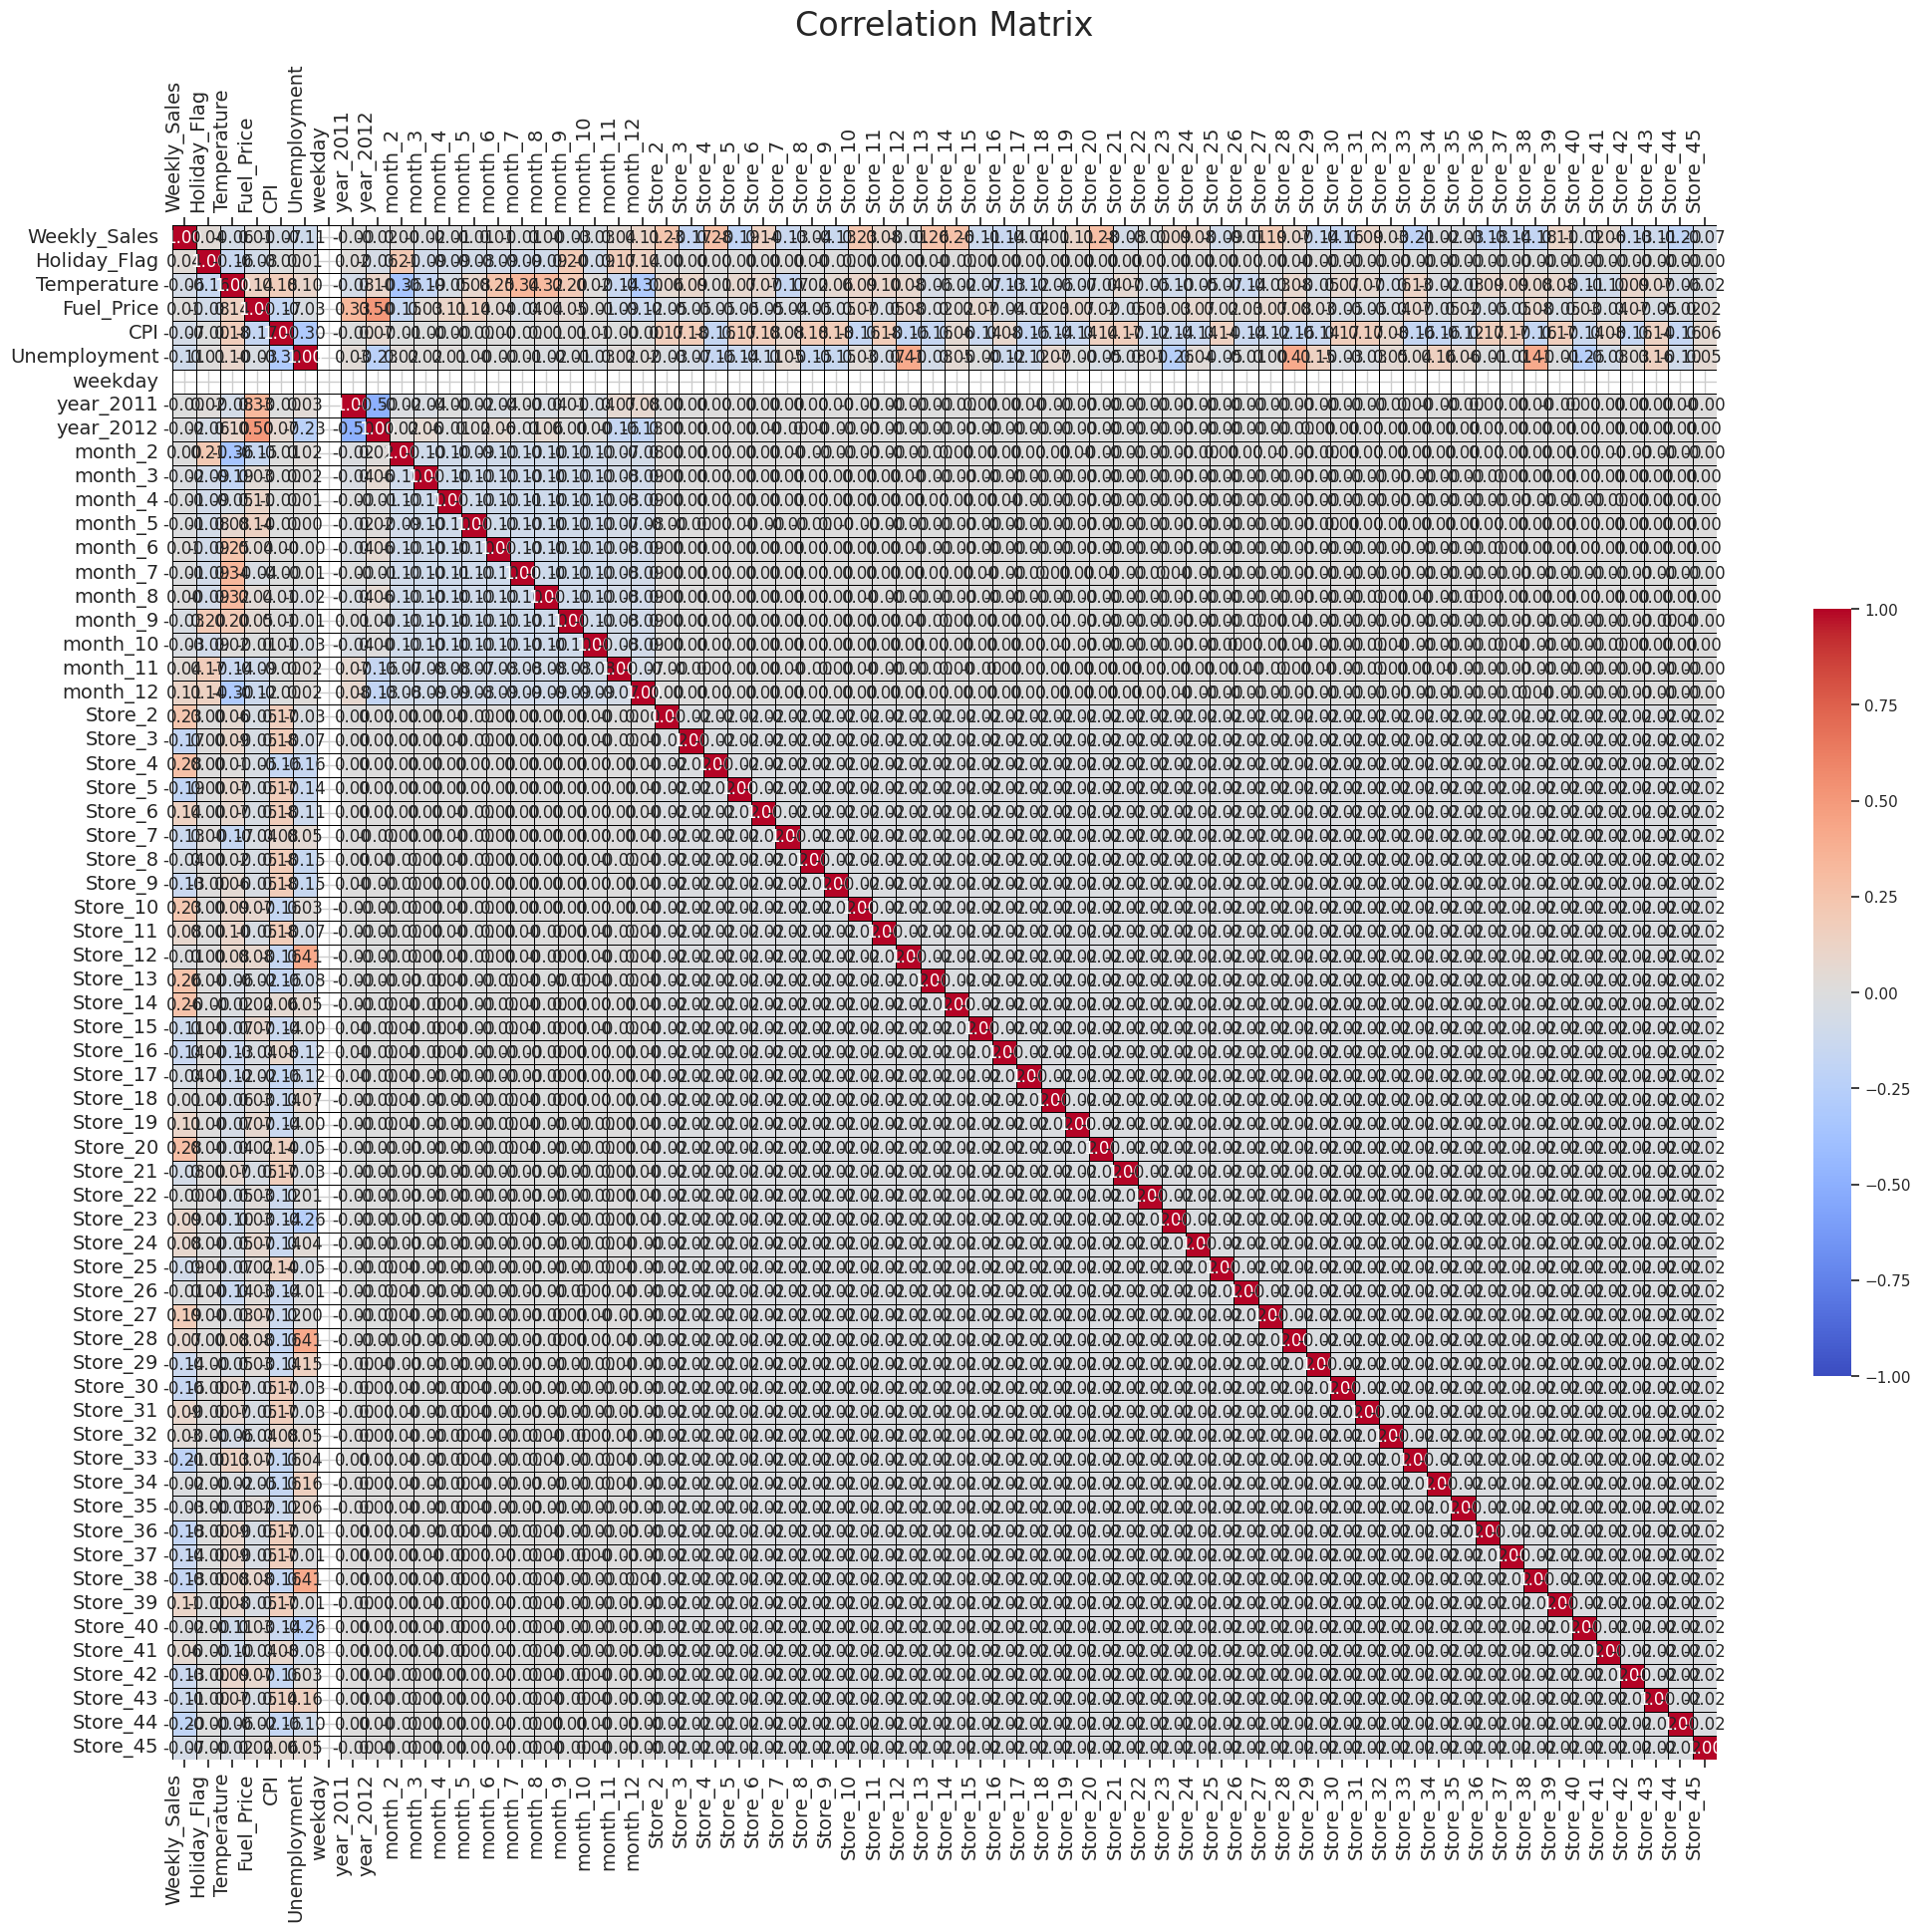

In [24]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=[25, 20])
heatmap = sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5, linecolor='black', cbar_kws={"shrink": .5})
plt.title('Correlation Matrix', fontsize=24, pad=20)

# Rotate the x-tick labels for better readability
plt.xticks(rotation=90, fontsize=14, ha='right')

# Set y-tick labels' font size
plt.yticks(fontsize=14)

# Duplicate x-axis labels on top
heatmap.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

# Rotate the top x-tick labels same as the bottom ones
plt.xticks(rotation=90, fontsize=14, ha='right')

plt.savefig("Python_Correlation_Matrix.png")
plt.show()

## Testing Linear Correlation

In [25]:
#Testing linear Regression models with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1192.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:07:03   Log-Likelihood:                -68411.
No. Observations:                5148   AIC:                         1.369e+05
Df Residuals:                    5085   BIC:                         1.374e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.051e+06   2003.943    524.425      0.000    1.05e+06    1.05e+06
Holiday_Flag  7538.1278   2221.980      3.393      0.001    3182.090    1.19e+04
Temperature   1.205e+04   7083.287      1.701      0.089   -1835.857    2.59e+04
Fuel_Price   -3157.3449   6570.137     -0.481      0.631    -1.6e+04    9722.954
CPI           1.551e+05   6.79e+04      2.283      0.022    2.19e+04    2.88e+05
Unemployment -6.711e+04   9388.698     -7.148      0.000   -8.55e+04   -4.87e+04
weekday       4.544e-11   1.97e-10      0.230      0.818   -3.41e-10    4.32e-10
year_2011    -1.133e+04   6985.595     -1.622      0.105    -2.5e+04    2365.748
year_2012    -2.226e+04   1.03e+04     -2.164      0.031   -4.24e+04   -2093.297
month_2        3.51e+04   3292.316     10.662      0.000    2.86e+04    4.16e+04
month_3       2.545e+04   3963.488      6.420      0.000    1.77e+04    3.32e+04
month_4       2.707e+04   4766.666      5.679      0.000    1.77e+04    3.64e+04
month_5       2.494e+04   5018.833      4.968      0.000    1.51e+04    3.48e+04
month_6       3.217e+04   5569.477      5.777      0.000    2.13e+04    4.31e+04
month_7       2.271e+04   6075.539      3.739      0.000    1.08e+04    3.46e+04
month_8       2.585e+04   6010.168      4.301      0.000    1.41e+04    3.76e+04
month_9       9443.3031   5569.977      1.695      0.090   -1476.250    2.04e+04
month_10      1.377e+04   4854.514      2.837      0.005    4257.656    2.33e+04
month_11      4.728e+04   3775.830     12.522      0.000    3.99e+04    5.47e+04
month_12      8.615e+04   3892.286     22.134      0.000    7.85e+04    9.38e+04
Store_2       5.478e+04   2808.158     19.509      0.000    4.93e+04    6.03e+04
Store_3      -1.743e+05   2941.979    -59.235      0.000    -1.8e+05   -1.69e+05
Store_4        1.21e+05   2.23e+04      5.416      0.000    7.72e+04    1.65e+05
Store_5       -1.86e+05   2917.225    -63.743      0.000   -1.92e+05    -1.8e+05
Store_6      -5220.2163   2939.810     -1.776      0.076    -1.1e+04     543.078
Store_7      -1.272e+05   6777.042    -18.768      0.000    -1.4e+05   -1.14e+05
Store_8      -1.077e+05   3235.229    -33.299      0.000   -1.14e+05   -1.01e+05
Store_9      -1.525e+05   3095.459    -49.267      0.000   -1.59e+05   -1.46e+05
Store_10      1.031e+05   2.18e+04      4.735      0.000    6.04e+04    1.46e+05
Store_11      -3.63e+04   2977.256    -12.191      0.000   -4.21e+04   -3.05e+04
Store_12     -1125.6048   2.32e+04     -0.049      0.961   -4.66e+04    4.43e+04
Store_13       1.14e+05   2.23e+04      5.119      0.000    7.03e+04    1.58e+05
Store_14      9.352e+04   8270.801     11.307      0.000    7.73e+04     1.1e+05
Store_15     -8.398e+04   1.99e+04     -4.216      0.000   -1.23e+05   -4.49e+04
Store_16     -1.436e+05   6347.579    -22.621      0.000   -1.56e+05   -1.31e+05
Store

## Fix multicollinearity issues with RMSE

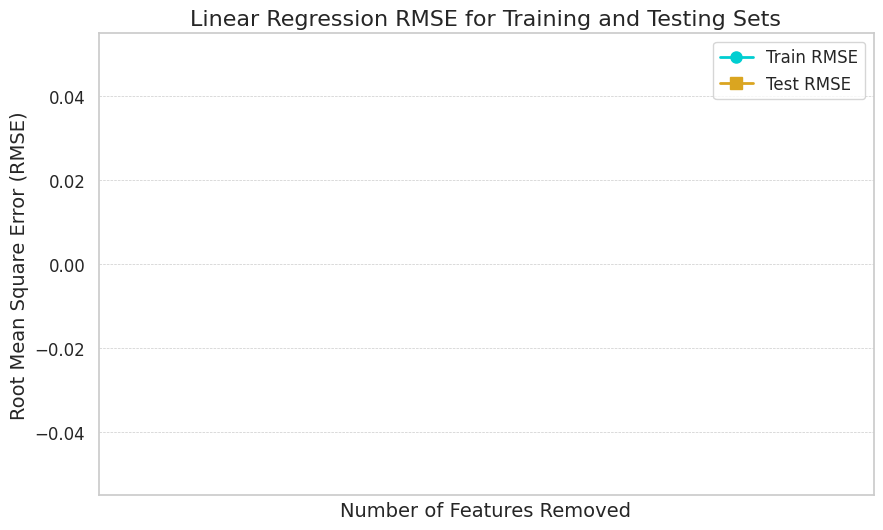

In [26]:
# Set the overall aesthetics to 'whitegrid' for a clean background
sns.set_theme(style="whitegrid")

Trr=[]; Tss=[]; n=3

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(Trr, '-o', label='Train RMSE', color='darkturquoise', linewidth=2, markersize=8)
plt.plot(Tss, '-s', label='Test RMSE', color='goldenrod', linewidth=2, markersize=8)

# Adding titles and labels
plt.title('Linear Regression RMSE for Training and Testing Sets', fontsize=16)
plt.xlabel('Number of Features Removed', fontsize=14)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=14)

# Customize ticks
plt.xticks(ticks=np.arange(len(Trr)), labels=[f'{i}' for i in range(1, len(Trr) + 1)], fontsize=12)
plt.yticks(fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Adding grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

## Shortlisting selected features with RFE method

In [27]:

lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-28)             # running RFE
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

159453.8037458573
152814.2067438803


# Predictive Model

In [28]:
#define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

## Checking Polinomical Regression model (all degrees)

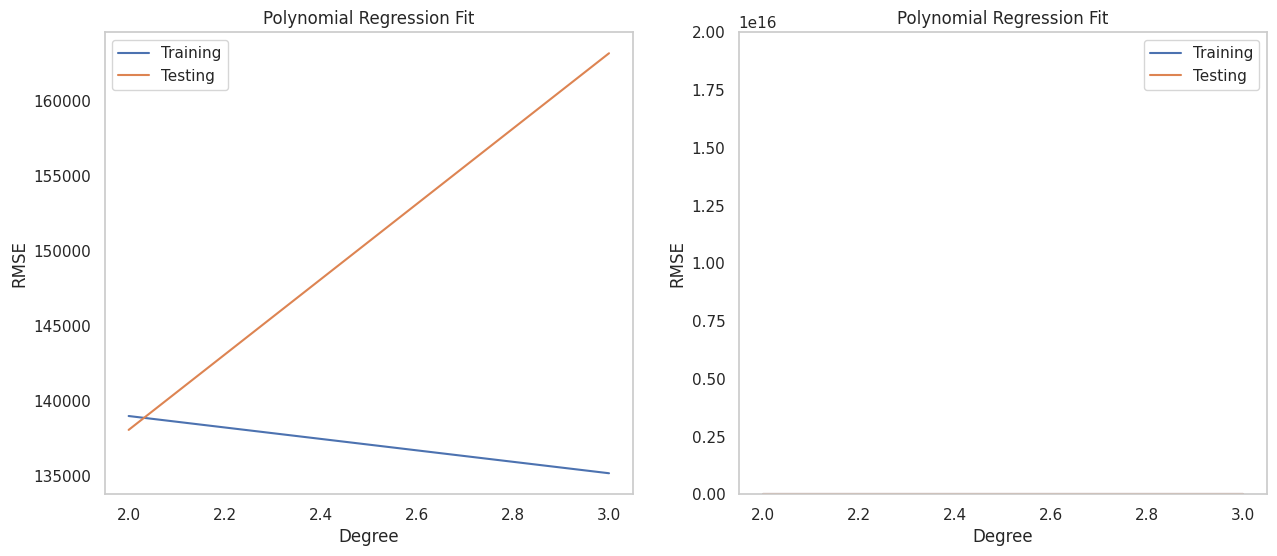

In [29]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=4

for i in range(2,n_degree):
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,2e16])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.savefig("Python_Polynomic_Regression_Fit.png")
plt.show()

## Checking Polinomical Regression model (degree=2)

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 157659.09948224  -54519.21234804   31409.91100403   66804.95421775
   76279.91566691 -152645.66951526  144134.62735439 -163808.09616526
 -109167.00420495  -85235.22301058 -130693.90474381  123942.37927169
  135212.50823599  112627.72109711  -65290.9763536  -123476.06909597
  -30257.33710657   48628.84936234  103294.1861213   -98344.67749989
   42415.93756659 -103839.54453043  103949.38262165   61523.24149687
  -72086.25676275 -144718.76824264 -114863.51935422 -149488.18975597
 -126236.60378147  -77258.71022972  -29732.45214369  -74766.65337785
 -101545.92338067 -114314.80453413  -70403.99248012]
The Intercept of the Regresion Model was found to be  1050918.228311966


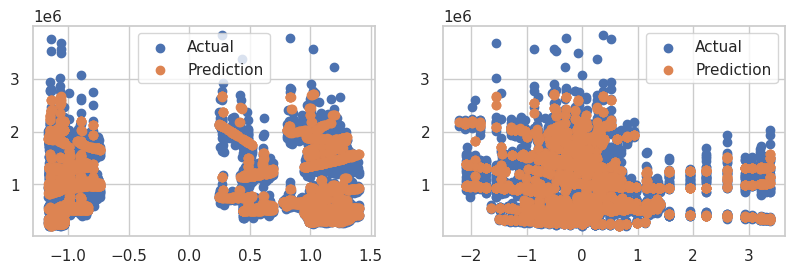



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9390824716485721
Residual Sum of Squares (RSS) on Training set  ---> 99464286463193.7
Mean Squared Error (MSE) on Training set       ---> 19320956966.432343
Root Mean Squared Error (RMSE) on Training set ---> 138999.84520290783

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9410346996896592
Residual Sum of Squares (RSS) on Training set  ---> 24536608287447.547
Mean Squared Error (MSE) on Training set       ---> 19064963704.310448
Root Mean Squared Error (RMSE) on Training set ---> 138075.93455888846

--------------------Residual Plots--------------------


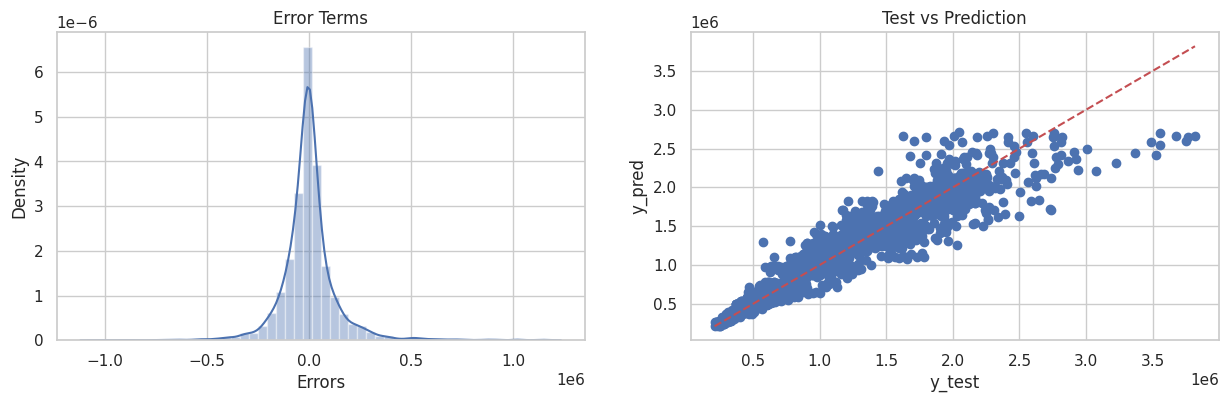

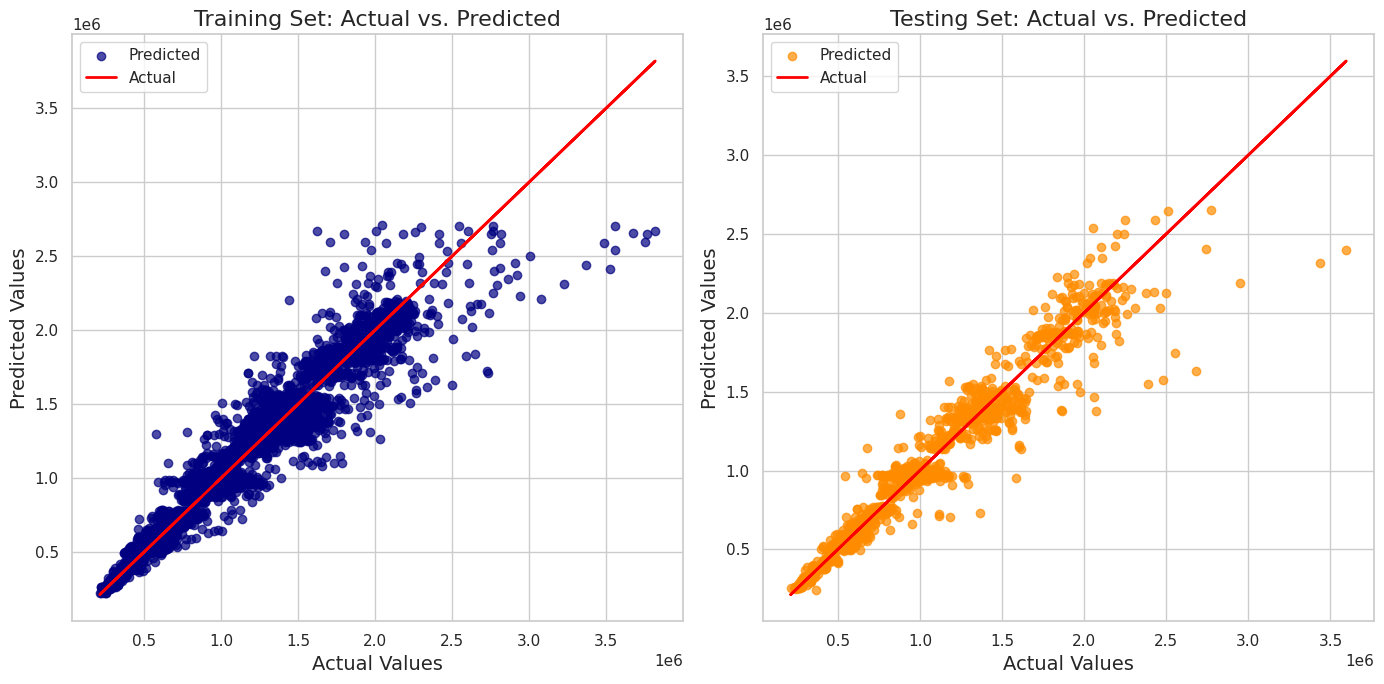

In [30]:
#Using the 2nd Order Polynomial Regression model (degree=2)

MLR = LinearRegression().fit(Train_X_std,Train_Y)
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

# focusing on visualizing the actual vs. predicted values

sns.set_theme(style="whitegrid")

# Plotting actual vs. predicted values for training set
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # Subplot 1 for training data
plt.scatter(Train_Y, pred1, alpha=0.7, color='navy', label='Predicted')
plt.savefig("Python_polynomic_regresson_test-prediction.png")
plt.plot(Train_Y, Train_Y, color='red', linewidth=2, label='Actual')
plt.title('Training Set: Actual vs. Predicted', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.legend()

# Plotting actual vs. predicted values for testing set
plt.subplot(1, 2, 2)  # Subplot 2 for testing data
plt.scatter(Test_Y, pred2, alpha=0.7, color='darkorange', label='Predicted')
plt.savefig("Python_Test_Prediction.png")
plt.plot(Test_Y, Test_Y, color='red', linewidth=2, label='Actual')
plt.title('Testing Set: Actual vs. Predicted', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.legend()

plt.tight_layout()
plt.savefig("Python_2ndOrder_regression.png")
plt.show()


## Formula to describe the model

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


# 'df' = DataFrame // 'target' = target variable
X = df.drop([target], axis=1)  # Features DataFrame
feature_names = X.columns.tolist()  # List of actual feature names

# Initialize and fit PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X)

#  'PR' is the trained Polynomial Regression model after fitting it with polynomial features
PR = LinearRegression()
PR.fit(X_poly, Y)

# Extract coefficients and intercept from the model
coefficients = PR.coef_
intercept = PR.intercept_

# Generate feature names for the polynomial features
poly_feature_names = poly_reg.get_feature_names_out(feature_names)

# Construct the model formula string
model_formula = f"Y = {intercept:.2f}"
for coef, name in zip(coefficients[1:], poly_feature_names[1:]):  # Skip the first term as it's the intercept
    model_formula += f" + ({coef:.2f})*{name}"

print("Final Model Formula:")
print(model_formula)


Final Model Formula:
Y = 348227513.94 + (-5085.53)*Holiday_Flag + (18090.31)*Temperature + (762267.05)*Fuel_Price + (-223138.29)*CPI + (507785.34)*Unemployment + (-0.01)*weekday + (433225.84)*year_2011 + (3204659.62)*year_2012 + (117627.08)*month_2 + (-303543.61)*month_3 + (-487148.18)*month_4 + (-699741.54)*month_5 + (-751720.94)*month_6 + (-605550.12)*month_7 + (-706117.51)*month_8 + (-636814.43)*month_9 + (-398207.13)*month_10 + (-586797.12)*month_11 + (-407850.46)*month_12 + (-83865.38)*Store_2 + (490150.51)*Store_3 + (-14422815.25)*Store_4 + (310148.34)*Store_5 + (490308.06)*Store_6 + (-4907780.85)*Store_7 + (1536183.90)*Store_8 + (1161012.76)*Store_9 + (-14925272.36)*Store_10 + (346632.00)*Store_11 + (-15975526.37)*Store_12 + (-15494554.43)*Store_13 + (-6736770.30)*Store_14 + (-13703517.08)*Store_15 + (-4066401.78)*Store_16 + (-14319166.41)*Store_17 + (-13473865.64)*Store_18 + (-13828765.01)*Store_19 + (-1285643.97)*Store_20 + (-587667.58)*Store_21 + (-13262650.99)*Store_22 + (-1